## Case study: stock market
In this notebook, we train the dynamical system model on a real dataset. In this case, we choose the stock market time series data. The task of this usecase is to create a neural network model with the dynamical system model as inner layer.

## Import libraries 
The first step is to observe the stock market data,

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DynamicalSystem.ODEModel import NNODEModel
from skorch import NeuralNetRegressor

/anaconda3/envs/semprojfall2019/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import the two to compare
from models import NeuralNetODEModel, FullyLinearLayerModel

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

## Data exploration
The first step is to observe the stock market data,

In [4]:
# import data
data_path = 'data/'
data = pd.read_parquet(data_path+'SPY_hourly.parquet')

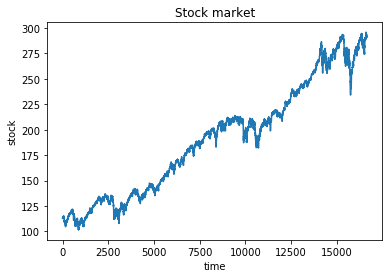

In [5]:
# plot data
plt.plot(data.values)
plt.title('Stock market')
plt.xlabel('time')
plt.ylabel('stock')
#plt.savefig('../figure/stock/stock.png')
plt.show()

In [6]:
# store values of data
price = data.values
price.shape

(16649, 1)

## Preprocessing
Before we create the model, we do some preprocessing on the dataset. First, we observe that the time series has a linear trend, we decide to keep this trend for our model. Since the observed values of the price are large, we start by standardizing the data.

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
def create_matrix_time(tensor, N):
    '''
    Create multiple time series of length N from one time serie.
    :param tensor (torch.Tensor): tensor of shape [time length, 1]
    :param N (int): time length of each time series
    :return:
    new_tensor (torch.Tensor): tensor containing all time series of length N.
    '''
    new_tensor = np.zeros([N, tensor.shape[0] - N + 1])
    for k in range(new_tensor.shape[1]):
        new_tensor[:,k] = tensor[k:(k + N)].squeeze()
    return new_tensor

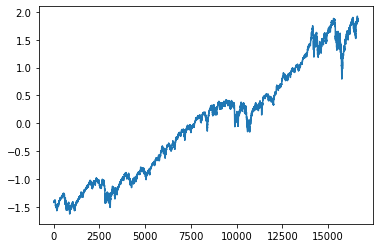

In [9]:
# Standardize data
scaler = StandardScaler().fit(price)
price_scale = scaler.transform(price)
plt.plot(price_scale)
plt.show()

We observe that the trend is conserved by the standardization operation. With this operation, we can improve the training of the neural network model by avoiding the fit on large values.

We need also to split the data set into training and test set and capture the input and target. The final step is to create a dataset containing time windows of length $N=10$ to train our model.

In [10]:
# split input target data
X = price_scale[:-5]
y = price_scale[5:]
print('Input shape',X.shape)
print('Target shape' ,y.shape)

Input shape (16644, 1)
Target shape (16644, 1)


In [11]:
N = 10
X_matrix = create_matrix_time(X, N).transpose()
y_matrix = create_matrix_time(y, N).transpose()
print('size')
print('Input size:', X_matrix.shape)
print('Target size:', y_matrix.shape)

size
Input size: (16635, 10)
Target size: (16635, 10)


In [12]:
# split train-test the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_matrix, test_size=0.2)
print('train size:', X_train.shape)
print('test_size:', X_test.shape)

train size: (13308, 10)
test_size: (3327, 10)


## Model training
Since the data are preprocessed, the next step is to fit our model. Since we want to observe the performance of the model with the dynamical system layer, we fit an other model which is composed of three fully connected layers and the main model is composed of two fully connected layers that play the role of encoder and decoder to transform the time series into a dynamical system so that we can use the dynamical system layer.

In [13]:
# import the two models to compare
from models import NeuralNetODEModel, FullyLinearLayerModel

In [19]:
# convert to torch.Tensor
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [15]:
#ode model implementation
in_dim = 10
out_dim = 10
hid_dim = 3
model_ode = NeuralNetODEModel(input_dim=in_dim, hidden_dim=hid_dim, output_dim=out_dim)
model_fc = FullyLinearLayerModel(input_dim=in_dim, hidden_dim=hid_dim, output_dim=out_dim)

In [16]:
#fit the neural ode model
ode_nn = NeuralNetRegressor(module=model_ode, criterion=nn.MSELoss, optimizer=optim.Adagrad, lr=1e-2, batch_size=10, max_epochs=1000)
ode_nn.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1065        0.0054  1.6561
      2        0.0024        0.0009  1.5799
      3        0.0007        0.0005  1.4705
      4        0.0005        0.0004  1.4451
      5        0.0005        0.0004  1.3780
      6        0.0004        0.0004  1.4730
      7        0.0004        0.0004  1.3635
      8        0.0004        0.0004  1.3632
      9        0.0004        0.0004  1.3899
     10        0.0004        0.0004  1.4875
     11        0.0004        0.0004  1.4186
     12        0.0004        0.0004  1.3802
     13        0.0004        0.0004  1.4692
     14        0.0004        0.0004  1.5213
     15        0.0004        0.0004  1.4632
     16        0.0004        0.0004  1.4627
     17        0.0004        0.0004  1.4431
     18        0.0004        0.0004  1.5179
     19        0.0004        0.0004  1.7094
     20        0.0004        0.0004  1.4271
     21        0.0004        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=NeuralNetODEModel(
    (encoder): Linear(in_features=10, out_features=3, bias=True)
    (ode): NNODEModel(
      (lin_ode): LinearODELayer()
      (nl_ode): NonLinearODELayer()
    )
    (decoder): Linear(in_features=3, out_features=10, bias=True)
  ),
)

In [17]:
#fit fc model
ode_fc = NeuralNetRegressor(module=model_fc, criterion=nn.MSELoss, optimizer=optim.Adagrad, lr=1e-2, batch_size=10, max_epochs=1000)
ode_fc.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0768        0.0006  1.0091
      2        0.0005        0.0004  0.9600
      3        0.0005        0.0004  1.2072
      4        0.0005        0.0004  1.0836
      5        0.0005        0.0004  0.9824
      6        0.0005        0.0004  0.9963
      7        0.0005        0.0004  0.9436
      8        0.0005        0.0004  0.9116
      9        0.0005        0.0004  0.9146
     10        0.0005        0.0004  0.9718
     11        0.0005        0.0004  0.9403
     12        0.0005        0.0004  0.9127
     13        0.0005        0.0004  0.9630
     14        0.0005        0.0004  0.9480
     15        0.0005        0.0004  0.9772
     16        0.0005        0.0004  0.9417
     17        0.0005        0.0004  0.9637
     18        0.0005        0.0004  0.9583
     19        0.0005        0.0004  0.9371
     20        0.0005        0.0004  0.9468
     21        0.0005        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=FullyLinearLayerModel(
    (encoder_layer): Linear(in_features=10, out_features=3, bias=True)
    (latent_layer): Linear(in_features=3, out_features=3, bias=True)
    (decoder_layer): Linear(in_features=3, out_features=10, bias=True)
  ),
)

Each model has been trained with the same data, then the next step is the computation of the prediction with each model and compare the last step time point of each model and compute the difference with the real value and use an histogram . 

In [20]:
# prediction computation
prediction_ode = ode_nn.predict(X_test)
prediction_fc = ode_fc.predict(X_test)
diff_ode = prediction_ode - y_test.numpy()
diff_fc = prediction_fc - y_test.numpy()

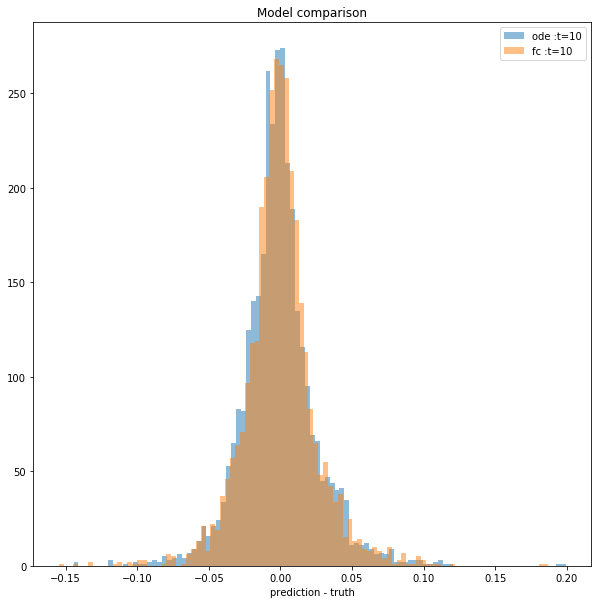

In [21]:
# plot the histogram
plt.figure(figsize=(10,10))
plt.hist(diff_ode[:,9], label='ode :t=10', alpha = 0.5, bins = 100);
plt.hist(diff_fc[:,9], label='fc :t=10', alpha = 0.5, bins = 100)
plt.title('Model comparison')
plt.xlabel('prediction - truth')
plt.legend()
plt.show()

We observe that the fully connected model tends to have a better performance than the ode model. This is due to the trend in the time series and the fact that the ﬁnancial time series are stochastic processes and contain a lot of noise or volatility in the data, then we need to choose better hyperparameters or improve the model by adding a part that can ﬁt the volatility in the data.

It is difficult to get an accurate prediction of for the market due to its complete randomness and unpredictability. Then we conclude an neural net containing the dynamical system layer has difficulties to predict financial time series.